## Generative adversarial networks

Как было сказано ранее, GAN обучается воспроизводить реальные данные. Поэтому Вам предлагается обучить генератор создавать точки, которые будут лежать на графике функции 

  $$y = \frac{\sin (x)}{x} - \frac{x}{10}$$

При выполнении данного задания структура GAN остается той же, но Вам нужно:
- Сгенерировать настоящие данные
- Изменить архитектуру дискриминатора и генератора
- Без графиков домашку не принимаю


In [1]:
import os
import numpy as np
import math
import torch
import torch.nn as nn
import torchvision 
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from torchvision.utils import save_image, make_grid
from torch.utils.data import DataLoader, Dataset
from torch.autograd import Variable
from IPython import display
from PIL import Image

%matplotlib inline

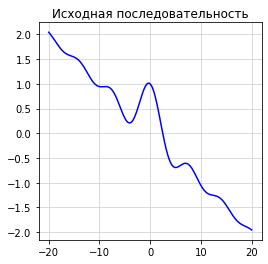

In [3]:
# Генерация графика

x = np.linspace(-20, 20, 1000) 

def func_y(x):
    return np.sin(x)/x - x/10

y = func_y(x)

PATH_TO_IMAGE ='/content/drive/MyDrive/y_plot.jpg'


plt.figure(figsize=(4, 4))
plt.plot(x, y, 'blue')
plt.grid(color="lightgrey")
plt.title('Исходная последовательность' )
plt.savefig(PATH_TO_IMAGE)
plt.show()

In [6]:
def sample_image(static_sample, save_img = False):
    npimg = make_grid(static_sample.data[:25]).cpu().numpy()
    fig, ax = plt.subplots(figsize=(7, 7))
    ax.imshow(np.transpose(npimg, (1,2,0)), interpolation="nearest")
    if save_img:
        save_image(gen_imgs.data[:25], "images/%d.png" % batches_done, nrow=5, normalize=True)

In [7]:
n_epochs = 300
batch_size = 64
lr = 0.0002

b1 = 0.5
b2 = 0.999

latent_dim = 100

n_classes = 1
img_size = 288
channels = 1

sample_interval = 25

img_shape = (channels, img_size, img_size)

In [8]:
img = Image.open(PATH_TO_IMAGE)

data_transforms = transforms.Compose([
    transforms.ToTensor()
])

real_imgTensor = data_transforms(img)
real_imgTensor.shape

torch.Size([3, 288, 288])

In [9]:
real_imgTensor = real_imgTensor[:1]
real_imgTensor.shape

torch.Size([1, 288, 288])

### Генератор 

In [10]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Использование таких словарей позволяет нам варьировать параметры нашей сети
        self.activations = nn.ModuleDict([
                ['lrelu', nn.LeakyReLU(0.2, inplace=True)],
                ['relu', nn.ReLU(0.2)]])
        
        def block(in_feat, out_feat, normalize=True, activation='relu'): #activation='relu
            layers = [nn.Linear(in_feat, out_feat)] # Если мы создаем последовательность слоев - то мы задаем их
                                                    # с помощью списка.
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(self.activations[activation]) # Эта сторчка означает тоже самое что и
                                                       # layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(latent_dim, 128, normalize=False), # Звездочка означает unpacking списка
            *block(128, 256, activation='lrelu'),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(np.prod(img_shape))),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), *img_shape)
        return img

### Дискриминатор

In [11]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()

        self.model = nn.Sequential(
            nn.Linear(int(np.prod(img_shape)), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        validity = self.model(img_flat)

        return validity

### Обучение

In [12]:
generator = Generator()
discriminator = Discriminator()

# Для каждой нейронки свой опитимизатор
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

# Но вот функция ошибки у нас будет одна общая
adversarial_loss = torch.nn.BCELoss()

In [13]:
d_loss_history = []
g_loss_history = []

[Epoch 299/300] [D loss: 0.6568154096603394] [G loss: 0.39205726981163025]


<Figure size 432x288 with 0 Axes>

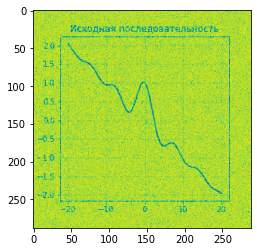

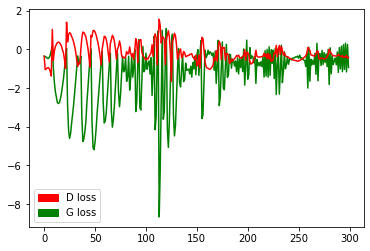

In [14]:
red_patch = mpatches.Patch(color='red', label='D loss')
green_patch = mpatches.Patch(color='green', label='G loss')

for epoch in range(n_epochs):
        
##################### Лейблы для данных: 1 - настоящие, 0 - сгенерированные ########

    valid = Variable(torch.FloatTensor(batch_size, 1).fill_(1.0), requires_grad=False)
    fake = Variable(torch.FloatTensor(batch_size, 1).fill_(0.0), requires_grad=False)
    
    real_imgs = Variable(real_imgTensor.type(torch.FloatTensor))
    
######################  Тренировка генератора    ##########################

    optimizer_G.zero_grad()
    
    # генерация шума
    z = Variable(torch.FloatTensor(np.random.normal(0, 1, (batch_size, latent_dim))))
    
    # Генерируем даные Генератором на основе шума
    gen_imgs = generator(z)
    
    # Подаем сгенерированые данные на Дискриминатор 
    validity = discriminator(gen_imgs)
    
    # Тут сравниваем предсказанные значения Дискриминатора(на основе сгенерировнных данных) с настоящими
    g_loss = adversarial_loss(validity, valid)
    
    # Делаем шаг обучения нашего Генератора
    g_loss.backward()
    optimizer_G.step()
    
######################  Тренировка дискриминатора    ##########################

    optimizer_D.zero_grad()
    
    # Получаем предсказания дискриминатора на основе реальных данных
    real_pred = discriminator(real_imgTensor)
    
    # Тут сравниваем предсказанные значения Дискриминатора(на основе настоящих данных) с настоящими
    d_real_loss = adversarial_loss(real_pred, valid[:1])
    
    # Опять делаем предсказание на Дискриминаторе с помощью сгенерированных данных
    fake_pred = discriminator(gen_imgs.detach())
    
    # расчитываем ошибку предсказанного с фейковыми лейблами
    d_fake_loss = adversarial_loss(fake_pred, fake)
    
    # И усредняем два лосса в один
    d_loss = (d_real_loss + d_fake_loss) / 2
    
    d_loss.backward()
    optimizer_D.step()
    
######## Отображение процесса обучения и вывод функций потерь ############
    with torch.no_grad():
        plt.clf()
        
        display.clear_output(wait=False)
        npimg = gen_imgs.data[0, 0].numpy()
        print(f"[Epoch {epoch}/{n_epochs}] [D loss: {d_loss.item()}] [G loss: {g_loss.item()}]") 

        display.display(plt.gcf())

        d_loss = d_loss.cpu().detach()
        g_loss = g_loss.cpu().detach()

        d_loss_history.append(d_loss)
        g_loss_history.append(g_loss)

        plt.imshow(npimg)
        plt.show()
        
        plt.plot(np.log(np.array(g_loss_history)), label='G loss', color = 'green')
        plt.plot(np.log(np.array(d_loss_history)), label='D loss', color = 'red')
        plt.legend(handles=[red_patch, green_patch])
        plt.show()

#### Выводы: 
- Loss Генератора так и не превзошел loss Дискриминатора 
- Амплитуда разброса у Генератора имеет больший диапозон, чем у Дискриминатора

In [33]:
count = 0 
for i in g_loss_history:
  count += i
print(count)

tensor(149.0107)


In [35]:
total = 0 
for i in d_loss_history:
  total += i
print(total)

tensor(291.6469)
